<a href="https://colab.research.google.com/github/ayushma18/Digit-recognition-from-scratch/blob/main/digit_recognition_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## ⚡ QUICK START: Upload and Predict Your Image

**Want to test immediately?** Follow these simple steps:

1. **Save your handwritten digit image** in this notebook's directory
2. **Update the filename** in the cell below
3. **Run the cell** to get your prediction!

---

In [ ]:
# ================================================================
# 🎯 UPLOAD YOUR IMAGE HERE
# ================================================================
#
# INSTRUCTIONS:
# 1. Place your handwritten digit image (0-9) in this directory
# 2. Update the filename below (e.g., "my_digit.png", "test.jpg")
# 3. Set INVERT_COLORS:
#    - True: if your digit is BLACK on WHITE background (most common)
#    - False: if your digit is WHITE on BLACK background (like MNIST)
# 4. Run this cell!
#
# NOTE: This cell will work AFTER you complete the training below.
# ================================================================

# YOUR IMAGE FILENAME HERE:
IMAGE_FILENAME = "my_digit.png"  # Change this to your image filename

# Color setting:
INVERT_COLORS = True  # True for black digit on white background

# ================================================================

import os

# Check if image exists
if os.path.exists(IMAGE_FILENAME):
    print("✅ Image found!")
    print(f"📁 File: {IMAGE_FILENAME}")
    print("\n⚠️ Make sure you have trained the model first by running all cells below.")
    print("\n📌 After training, re-run this cell to see your prediction!")

    # Try to make prediction (will work after training)
    try:
        from PIL import Image
        import numpy as np

        # Display the uploaded image
        img = Image.open(IMAGE_FILENAME)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray')
        plt.title("Your Uploaded Image", fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()

        # Try prediction if model is trained
        if 'trained_parameters' in dir():
            predicted_digit, confidence, probabilities, _, _ = predict_digit(
                IMAGE_FILENAME,
                trained_parameters,
                invert=INVERT_COLORS
            )

            print("\n" + "="*70)
            print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
            print("="*70)
            print(f"Confidence: {confidence*100:.2f}%")
            print("\nTop 3 predictions:")
            top_3 = np.argsort(probabilities)[-3:][::-1]
            for i, idx in enumerate(top_3, 1):
                print(f"  {i}. Digit {idx}: {probabilities[idx]*100:.2f}%")
            print("="*70)

            # Display with visualization
            display_prediction(IMAGE_FILENAME, trained_parameters, invert=INVERT_COLORS)
        else:
            print("\n⚠️ Model not trained yet. Please run all cells below to train the model first.")

    except NameError:
        print("\n⚠️ Prediction functions not loaded yet.")
        print("Please run all cells in this notebook first to:")
        print("  1. Define the prediction functions")
        print("  2. Train the neural network")
        print("  3. Then come back and re-run this cell")
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")

else:
    print(f"❌ Image file '{IMAGE_FILENAME}' not found!")
    print("\n📋 To upload your image:")
    print("  1. Save your handwritten digit image (PNG, JPG, JPEG)")
    print("  2. Place it in this notebook's directory:")
    print(f"     {os.getcwd()}")
    print(f"  3. Update IMAGE_FILENAME variable above")
    print("  4. Run this cell again")
    print("\n💡 You can also drag-and-drop the image file into the file browser.")


# Handwritten Digit Recognition from Scratch

**Built Without Deep Learning Libraries**

This notebook implements a complete neural network from scratch to recognize handwritten digits (0-9) from images.

## Key Features:
- No TensorFlow, PyTorch, or Keras
- Pure algorithmic implementation using NumPy
- Detailed mathematical explanations
- Custom image input support
- Output format: "The uploaded handwritten digit is recognized as: X"

## Architecture:
- Input Layer: 784 neurons (28x28 pixels)
- Hidden Layer: 128 neurons (ReLU activation)
- Output Layer: 10 neurons (Softmax activation)
- Training: Backpropagation with mini-batch gradient descent

## 1. Import Required Libraries

We'll use only basic libraries:
- **NumPy**: For numerical operations and matrix computations
- **Matplotlib**: For visualization
- **PIL (Pillow)**: For image loading and preprocessing
- **urllib**: For downloading MNIST dataset
- **gzip**: For decompressing dataset files

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import gzip
import os
import pickle

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.0.2


## 2. Load and Preprocess the MNIST Dataset

The MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits.

### Process:
1. Download the dataset from the official source
2. Extract images and labels
3. Normalize pixel values from [0, 255] to [0, 1]
4. Flatten 28x28 images into 784-dimensional vectors
5. One-hot encode labels for classification

In [5]:
def download_mnist():
    """Download MNIST dataset from the internet"""
    base_url = "http://yann.lecun.com/exdb/mnist/"
    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }

    data_dir = "mnist_data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for key, filename in files.items():
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(base_url + filename, filepath)
            print(f"Downloaded {filename}")
        else:
            print(f"{filename} already exists")

    return data_dir

def load_mnist_images(filepath):
    """Load MNIST images from compressed file"""
    with gzip.open(filepath, 'rb') as f:
        # Read header information
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')

        # Read image data
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)

    return data

def load_mnist_labels(filepath):
    """Load MNIST labels from compressed file"""
    with gzip.open(filepath, 'rb') as f:
        # Read header information
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')

        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

def preprocess_data(images, labels):
    """
    Preprocess images and labels for neural network

    Steps:
    1. Flatten 28x28 images to 784-dimensional vectors
    2. Normalize pixel values from [0, 255] to [0, 1]
    3. One-hot encode labels
    """
    # Flatten images: (num_samples, 28, 28) -> (num_samples, 784)
    X = images.reshape(images.shape[0], -1)

    # Normalize pixel values to [0, 1]
    X = X.astype(np.float32) / 255.0

    # One-hot encode labels
    # Example: label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    num_classes = 10
    Y = np.zeros((labels.shape[0], num_classes))
    Y[np.arange(labels.shape[0]), labels] = 1

    return X, Y

# Download and load the dataset
print("=" * 60)
print("LOADING MNIST DATASET")
print("=" * 60)

data_dir = download_mnist()

# Load training data
train_images = load_mnist_images(os.path.join(data_dir, "train-images-idx3-ubyte.gz"))
train_labels = load_mnist_labels(os.path.join(data_dir, "train-labels-idx1-ubyte.gz"))

# Load test data
test_images = load_mnist_images(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"))
test_labels = load_mnist_labels(os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz"))

print(f"\nRaw Data Shapes:")
print(f"Training images: {train_images.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}")
print(f"Test labels: {test_labels.shape}")

# Preprocess the data
X_train, Y_train = preprocess_data(train_images, train_labels)
X_test, Y_test = preprocess_data(test_images, test_labels)

print(f"\nPreprocessed Data Shapes:")
print(f"X_train: {X_train.shape} (flattened and normalized)")
print(f"Y_train: {Y_train.shape} (one-hot encoded)")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

print(f"\nData Statistics:")
print(f"Pixel value range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Number of classes: {Y_train.shape[1]}")
print("=" * 60)

LOADING MNIST DATASET


HTTPError: HTTP Error 404: Not Found

## 3. Visualize Sample Digits

Let's visualize some sample handwritten digits from the training dataset to understand what our neural network will be learning from.

NameError: name 'train_images' is not defined

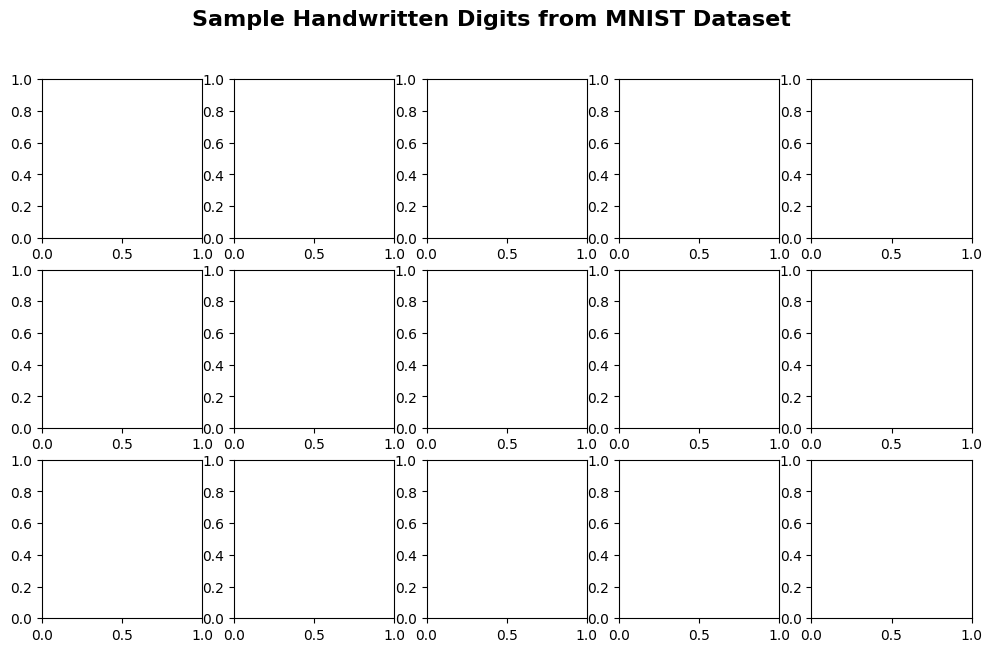

In [3]:
# Visualize 15 random samples from the training set
num_samples = 15
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
fig.suptitle('Sample Handwritten Digits from MNIST Dataset', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Random index
    idx = np.random.randint(0, len(train_images))

    # Display the image
    ax.imshow(train_images[idx], cmap='gray')
    ax.set_title(f'Label: {train_labels[idx]}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Each image is 28x28 pixels representing a handwritten digit (0-9)")

## 4. Initialize Neural Network Parameters

### Network Architecture:
- **Input Layer**: 784 neurons (28×28 pixels)
- **Hidden Layer 1**: 128 neurons with ReLU activation
- **Output Layer**: 10 neurons (digits 0-9) with Softmax activation

### Weight Initialization:
We use **He initialization** for ReLU layers:
$$W \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n_{in}}}\right)$$

Where $n_{in}$ is the number of input neurons to the layer.

In [ ]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Initialize weights and biases for a 2-layer neural network

    Parameters:
    -----------
    input_size : int
        Number of input features (784 for flattened 28x28 images)
    hidden_size : int
        Number of neurons in the hidden layer
    output_size : int
        Number of output classes (10 for digits 0-9)

    Returns:
    --------
    parameters : dict
        Dictionary containing initialized weights and biases
    """

    # He initialization for ReLU activation (hidden layer)
    # Multiply by sqrt(2/n) where n is the number of inputs
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
    b1 = np.zeros((1, hidden_size))

    # Xavier initialization for output layer
    # Multiply by sqrt(1/n) where n is the number of inputs
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)
    b2 = np.zeros((1, output_size))

    parameters = {
        'W1': W1,  # Shape: (784, 128)
        'b1': b1,  # Shape: (1, 128)
        'W2': W2,  # Shape: (128, 10)
        'b2': b2   # Shape: (1, 10)
    }

    return parameters

# Define network architecture
INPUT_SIZE = 784   # 28x28 pixels
HIDDEN_SIZE = 128  # Hidden layer neurons
OUTPUT_SIZE = 10   # 10 classes (digits 0-9)

# Initialize parameters
parameters = initialize_parameters(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

print("=" * 60)
print("NEURAL NETWORK PARAMETERS INITIALIZED")
print("=" * 60)
print(f"\nNetwork Architecture:")
print(f"  Input Layer:  {INPUT_SIZE} neurons")
print(f"  Hidden Layer: {HIDDEN_SIZE} neurons (ReLU)")
print(f"  Output Layer: {OUTPUT_SIZE} neurons (Softmax)")

print(f"\nParameter Shapes:")
print(f"  W1 (Input → Hidden):  {parameters['W1'].shape}")
print(f"  b1 (Hidden bias):     {parameters['b1'].shape}")
print(f"  W2 (Hidden → Output): {parameters['W2'].shape}")
print(f"  b2 (Output bias):     {parameters['b2'].shape}")

# Calculate total number of parameters
total_params = (parameters['W1'].size + parameters['b1'].size +
                parameters['W2'].size + parameters['b2'].size)
print(f"\nTotal trainable parameters: {total_params:,}")
print("=" * 60)

## 5. Implement Activation Functions

### ReLU (Rectified Linear Unit)
$$f(x) = \max(0, x)$$
$$f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$

### Softmax
$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

Converts raw scores to probability distribution over classes.

In [ ]:
def relu(Z):
    """
    ReLU activation function: f(x) = max(0, x)

    Parameters:
    -----------
    Z : numpy array
        Input to the activation function

    Returns:
    --------
    A : numpy array
        Output after applying ReLU
    """
    return np.maximum(0, Z)

def relu_derivative(Z):
    """
    Derivative of ReLU function

    Parameters:
    -----------
    Z : numpy array
        Input to the activation function

    Returns:
    --------
    dZ : numpy array
        Gradient of ReLU
    """
    return (Z > 0).astype(float)

def softmax(Z):
    """
    Softmax activation function
    Converts scores to probability distribution

    Parameters:
    -----------
    Z : numpy array of shape (batch_size, num_classes)
        Raw scores from the output layer

    Returns:
    --------
    A : numpy array of shape (batch_size, num_classes)
        Probabilities for each class (sum to 1 across classes)
    """
    # Subtract max for numerical stability (prevents overflow)
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Test activation functions
print("=" * 60)
print("TESTING ACTIVATION FUNCTIONS")
print("=" * 60)

# Test ReLU
test_input = np.array([[-2, -1, 0, 1, 2]])
print("\nReLU Test:")
print(f"  Input:  {test_input[0]}")
print(f"  Output: {relu(test_input)[0]}")
print(f"  Derivative: {relu_derivative(test_input)[0]}")

# Test Softmax
test_scores = np.array([[2.0, 1.0, 0.1]])
softmax_output = softmax(test_scores)
print("\nSoftmax Test:")
print(f"  Input scores: {test_scores[0]}")
print(f"  Output probabilities: {softmax_output[0]}")
print(f"  Sum of probabilities: {np.sum(softmax_output):.6f} (should be 1.0)")
print("=" * 60)

## 6. Implement Forward Propagation

Forward propagation computes the output of the neural network given an input.

### Mathematical Steps:

**Layer 1 (Input → Hidden):**
$$Z_1 = XW_1 + b_1$$
$$A_1 = \text{ReLU}(Z_1) = \max(0, Z_1)$$

**Layer 2 (Hidden → Output):**
$$Z_2 = A_1W_2 + b_2$$
$$A_2 = \text{Softmax}(Z_2)$$

Where:
- $X$ is the input (batch of images)
- $W_1, b_1$ are weights and biases for hidden layer
- $W_2, b_2$ are weights and biases for output layer
- $A_1$ is the activation of hidden layer
- $A_2$ is the final output (class probabilities)

In [ ]:
def forward_propagation(X, parameters):
    """
    Perform forward propagation through the neural network

    Parameters:
    -----------
    X : numpy array of shape (batch_size, 784)
        Input data (flattened images)
    parameters : dict
        Dictionary containing W1, b1, W2, b2

    Returns:
    --------
    A2 : numpy array of shape (batch_size, 10)
        Output layer activations (class probabilities)
    cache : dict
        Intermediate values needed for backpropagation
    """

    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Layer 1: Input → Hidden
    # Z1 = X @ W1 + b1
    Z1 = np.dot(X, W1) + b1        # Shape: (batch_size, 128)
    A1 = relu(Z1)                   # Shape: (batch_size, 128)

    # Layer 2: Hidden → Output
    # Z2 = A1 @ W2 + b2
    Z2 = np.dot(A1, W2) + b2       # Shape: (batch_size, 10)
    A2 = softmax(Z2)                # Shape: (batch_size, 10)

    # Store values for backpropagation
    cache = {
        'X': X,
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }

    return A2, cache

# Test forward propagation with a small batch
print("=" * 60)
print("TESTING FORWARD PROPAGATION")
print("=" * 60)

# Test with 5 random samples
test_batch = X_train[:5]
predictions, cache = forward_propagation(test_batch, parameters)

print(f"\nInput shape: {test_batch.shape}")
print(f"Output shape: {predictions.shape}")
print(f"\nPredictions (probabilities for each class):")
for i in range(5):
    predicted_digit = np.argmax(predictions[i])
    confidence = predictions[i][predicted_digit]
    actual_digit = np.argmax(Y_train[i])
    print(f"  Sample {i+1}: Predicted={predicted_digit} (confidence={confidence:.4f}), Actual={actual_digit}")

print(f"\nCache contains: {list(cache.keys())}")
print("=" * 60)

## 7. Implement Loss Function

We use **Cross-Entropy Loss** for multi-class classification:

$$\mathcal{L} = -\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})$$

Where:
- $m$ is the batch size
- $C$ is the number of classes (10)
- $y_{ij}$ is the true label (one-hot encoded)
- $\hat{y}_{ij}$ is the predicted probability
- The loss measures how different predictions are from true labels

In [ ]:
def compute_loss(A2, Y):
    """
    Compute cross-entropy loss

    Parameters:
    -----------
    A2 : numpy array of shape (batch_size, 10)
        Predicted probabilities from output layer
    Y : numpy array of shape (batch_size, 10)
        True labels (one-hot encoded)

    Returns:
    --------
    loss : float
        Cross-entropy loss value
    """
    m = Y.shape[0]  # Number of samples

    # Add small epsilon to prevent log(0)
    epsilon = 1e-8

    # Cross-entropy loss: -1/m * sum(y * log(y_hat))
    loss = -np.sum(Y * np.log(A2 + epsilon)) / m

    return loss

def compute_accuracy(A2, Y):
    """
    Compute classification accuracy

    Parameters:
    -----------
    A2 : numpy array of shape (batch_size, 10)
        Predicted probabilities
    Y : numpy array of shape (batch_size, 10)
        True labels (one-hot encoded)

    Returns:
    --------
    accuracy : float
        Percentage of correct predictions
    """
    # Get predicted class (highest probability)
    predictions = np.argmax(A2, axis=1)

    # Get true class
    true_labels = np.argmax(Y, axis=1)

    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels) * 100

    return accuracy

# Test loss function
print("=" * 60)
print("TESTING LOSS FUNCTION")
print("=" * 60)

test_predictions, _ = forward_propagation(X_train[:100], parameters)
test_labels = Y_train[:100]

loss = compute_loss(test_predictions, test_labels)
accuracy = compute_accuracy(test_predictions, test_labels)

print(f"\nTest on 100 samples (untrained network):")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.2f}%")
print(f"  Random guessing would give ~10% accuracy")
print("=" * 60)

## 8. Implement Backpropagation

Backpropagation computes gradients of the loss with respect to all parameters using the **chain rule**.

### Mathematical Derivation:

**Output Layer Gradients:**
$$\frac{\partial \mathcal{L}}{\partial Z_2} = A_2 - Y$$
$$\frac{\partial \mathcal{L}}{\partial W_2} = \frac{1}{m} A_1^T (A_2 - Y)$$
$$\frac{\partial \mathcal{L}}{\partial b_2} = \frac{1}{m} \sum (A_2 - Y)$$

**Hidden Layer Gradients:**
$$\frac{\partial \mathcal{L}}{\partial Z_1} = \frac{\partial \mathcal{L}}{\partial Z_2} \cdot W_2^T \odot \text{ReLU}'(Z_1)$$
$$\frac{\partial \mathcal{L}}{\partial W_1} = \frac{1}{m} X^T \frac{\partial \mathcal{L}}{\partial Z_1}$$
$$\frac{\partial \mathcal{L}}{\partial b_1} = \frac{1}{m} \sum \frac{\partial \mathcal{L}}{\partial Z_1}$$

Where $\odot$ denotes element-wise multiplication.

In [ ]:
def backward_propagation(cache, Y, parameters):
    """
    Perform backward propagation to compute gradients

    Parameters:
    -----------
    cache : dict
        Contains intermediate values from forward propagation
    Y : numpy array of shape (batch_size, 10)
        True labels (one-hot encoded)
    parameters : dict
        Current weights and biases

    Returns:
    --------
    gradients : dict
        Dictionary containing gradients for all parameters
    """

    m = Y.shape[0]  # Batch size

    # Extract values from cache
    X = cache['X']
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']

    # Extract parameters
    W2 = parameters['W2']

    # ==========================================
    # BACKWARD PASS - Layer 2 (Output Layer)
    # ==========================================

    # Gradient of loss with respect to Z2
    # For softmax + cross-entropy: dZ2 = A2 - Y
    dZ2 = A2 - Y  # Shape: (batch_size, 10)

    # Gradient of loss with respect to W2
    # dW2 = (1/m) * A1^T @ dZ2
    dW2 = (1/m) * np.dot(A1.T, dZ2)  # Shape: (128, 10)

    # Gradient of loss with respect to b2
    # db2 = (1/m) * sum(dZ2) across samples
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)  # Shape: (1, 10)

    # ==========================================
    # BACKWARD PASS - Layer 1 (Hidden Layer)
    # ==========================================

    # Gradient flowing back from layer 2
    # dA1 = dZ2 @ W2^T
    dA1 = np.dot(dZ2, W2.T)  # Shape: (batch_size, 128)

    # Apply ReLU derivative
    # dZ1 = dA1 * ReLU'(Z1)
    dZ1 = dA1 * relu_derivative(Z1)  # Shape: (batch_size, 128)

    # Gradient of loss with respect to W1
    # dW1 = (1/m) * X^T @ dZ1
    dW1 = (1/m) * np.dot(X.T, dZ1)  # Shape: (784, 128)

    # Gradient of loss with respect to b1
    # db1 = (1/m) * sum(dZ1) across samples
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)  # Shape: (1, 128)

    # Store all gradients
    gradients = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }

    return gradients

# Test backpropagation
print("=" * 60)
print("TESTING BACKPROPAGATION")
print("=" * 60)

# Forward pass
test_batch = X_train[:32]
test_labels = Y_train[:32]
predictions, cache = forward_propagation(test_batch, parameters)

# Backward pass
gradients = backward_propagation(cache, test_labels, parameters)

print(f"\nGradient Shapes:")
print(f"  dW1: {gradients['dW1'].shape} (should match W1: {parameters['W1'].shape})")
print(f"  db1: {gradients['db1'].shape} (should match b1: {parameters['b1'].shape})")
print(f"  dW2: {gradients['dW2'].shape} (should match W2: {parameters['W2'].shape})")
print(f"  db2: {gradients['db2'].shape} (should match b2: {parameters['b2'].shape})")

print(f"\nSample Gradient Statistics:")
print(f"  dW1 - mean: {np.mean(gradients['dW1']):.6f}, std: {np.std(gradients['dW1']):.6f}")
print(f"  dW2 - mean: {np.mean(gradients['dW2']):.6f}, std: {np.std(gradients['dW2']):.6f}")
print("=" * 60)

## 9. Implement Gradient Descent

Gradient descent updates parameters in the direction that reduces the loss:

$$W := W - \alpha \frac{\partial \mathcal{L}}{\partial W}$$
$$b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}$$

Where $\alpha$ is the **learning rate** that controls the step size.

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    """
    Update parameters using gradient descent

    Parameters:
    -----------
    parameters : dict
        Current weights and biases
    gradients : dict
        Gradients computed from backpropagation
    learning_rate : float
        Step size for parameter updates

    Returns:
    --------
    parameters : dict
        Updated weights and biases
    """

    # Update weights and biases for layer 1
    parameters['W1'] = parameters['W1'] - learning_rate * gradients['dW1']
    parameters['b1'] = parameters['b1'] - learning_rate * gradients['db1']

    # Update weights and biases for layer 2
    parameters['W2'] = parameters['W2'] - learning_rate * gradients['dW2']
    parameters['b2'] = parameters['b2'] - learning_rate * gradients['db2']

    return parameters

# Test parameter update
print("=" * 60)
print("TESTING PARAMETER UPDATE")
print("=" * 60)

# Store original parameter values
original_W1 = parameters['W1'].copy()

# Perform one update
learning_rate = 0.01
parameters = update_parameters(parameters, gradients, learning_rate)

# Check if parameters changed
param_change = np.mean(np.abs(parameters['W1'] - original_W1))
print(f"\nLearning rate: {learning_rate}")
print(f"Average change in W1: {param_change:.8f}")
print("Parameters updated successfully!")

# Re-initialize for training
parameters = initialize_parameters(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
print("\nParameters re-initialized for training")
print("=" * 60)

## 10. Train the Neural Network

Now we combine all components to train the neural network using **mini-batch gradient descent**.

### Training Process:
1. Split training data into mini-batches
2. For each epoch:
   - Shuffle the data
   - For each mini-batch:
     - Forward propagation
     - Compute loss
     - Backward propagation
     - Update parameters
   - Track loss and accuracy

### Hyperparameters:
- **Epochs**: 10 (number of complete passes through training data)
- **Batch size**: 128 (number of samples per mini-batch)
- **Learning rate**: 0.1 (step size for gradient descent)

In [ ]:
def train_neural_network(X_train, Y_train, X_val, Y_val, epochs=10, batch_size=128, learning_rate=0.1):
    """
    Train the neural network using mini-batch gradient descent

    Parameters:
    -----------
    X_train : numpy array
        Training data
    Y_train : numpy array
        Training labels (one-hot encoded)
    X_val : numpy array
        Validation data
    Y_val : numpy array
        Validation labels (one-hot encoded)
    epochs : int
        Number of complete passes through training data
    batch_size : int
        Number of samples per mini-batch
    learning_rate : float
        Step size for gradient descent

    Returns:
    --------
    parameters : dict
        Trained weights and biases
    history : dict
        Training history (loss and accuracy over epochs)
    """

    # Initialize parameters
    parameters = initialize_parameters(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size

    print("=" * 70)
    print("TRAINING NEURAL NETWORK")
    print("=" * 70)
    print(f"Training samples: {num_samples}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Batches per epoch: {num_batches}")
    print(f"Learning rate: {learning_rate}")
    print("=" * 70)

    # Training loop
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_shuffled = X_train[indices]
        Y_shuffled = Y_train[indices]

        epoch_loss = 0
        epoch_correct = 0

        # Mini-batch training
        for batch in range(num_batches):
            # Get mini-batch
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            Y_batch = Y_shuffled[start_idx:end_idx]

            # Forward propagation
            A2, cache = forward_propagation(X_batch, parameters)

            # Compute loss
            batch_loss = compute_loss(A2, Y_batch)
            epoch_loss += batch_loss

            # Count correct predictions
            predictions = np.argmax(A2, axis=1)
            true_labels = np.argmax(Y_batch, axis=1)
            epoch_correct += np.sum(predictions == true_labels)

            # Backward propagation
            gradients = backward_propagation(cache, Y_batch, parameters)

            # Update parameters
            parameters = update_parameters(parameters, gradients, learning_rate)

        # Calculate epoch metrics
        train_loss = epoch_loss / num_batches
        train_acc = (epoch_correct / num_samples) * 100

        # Validation
        val_predictions, _ = forward_propagation(X_val, parameters)
        val_loss = compute_loss(val_predictions, Y_val)
        val_acc = compute_accuracy(val_predictions, Y_val)

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    print("=" * 70)
    print("TRAINING COMPLETE!")
    print("=" * 70)

    return parameters, history

# Split training data into train and validation sets
split_idx = 50000
X_train_split = X_train[:split_idx]
Y_train_split = Y_train[:split_idx]
X_val = X_train[split_idx:]
Y_val = Y_train[split_idx:]

print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print()

# Train the network
trained_parameters, training_history = train_neural_network(
    X_train_split,
    Y_train_split,
    X_val,
    Y_val,
    epochs=10,
    batch_size=128,
    learning_rate=0.1
)

### Visualize Training Progress

Let's plot the training and validation loss/accuracy over epochs to see how well the model learned.

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
epochs_range = range(1, len(training_history['train_loss']) + 1)
ax1.plot(epochs_range, training_history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, training_history['val_loss'], 'r-s', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_range, training_history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, training_history['val_acc'], 'r-s', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {training_history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {training_history['val_acc'][-1]:.2f}%")

## 11. Evaluate Model Accuracy

Let's evaluate the trained model on the test dataset to see how well it generalizes to unseen data.

In [ ]:
# Evaluate on test set
print("=" * 60)
print("EVALUATING MODEL ON TEST SET")
print("=" * 60)

# Make predictions on test set
test_predictions, _ = forward_propagation(X_test, trained_parameters)
test_loss = compute_loss(test_predictions, Y_test)
test_acc = compute_accuracy(test_predictions, Y_test)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.2f}%")
print(f"  Correct predictions: {int(test_acc * len(X_test) / 100)} / {len(X_test)}")
print("=" * 60)

# Show some correct and incorrect predictions
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(Y_test, axis=1)
correct_mask = (predicted_labels == true_labels)
incorrect_mask = ~correct_mask

# Visualize correct predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Correct Predictions', fontsize=16, fontweight='bold')

correct_indices = np.where(correct_mask)[0][:10]
for i, ax in enumerate(axes.flat):
    idx = correct_indices[i]
    ax.imshow(test_images[idx], cmap='gray')
    confidence = test_predictions[idx][predicted_labels[idx]]
    ax.set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}\nConf: {confidence:.2f}',
                 fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize incorrect predictions
if np.sum(incorrect_mask) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('Incorrect Predictions (if any)', fontsize=16, fontweight='bold', color='red')

    incorrect_indices = np.where(incorrect_mask)[0][:10]
    for i, ax in enumerate(axes.flat):
        if i < len(incorrect_indices):
            idx = incorrect_indices[i]
            ax.imshow(test_images[idx], cmap='gray')
            confidence = test_predictions[idx][predicted_labels[idx]]
            ax.set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}\nConf: {confidence:.2f}',
                         fontsize=10, color='red')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## 12. Load and Preprocess Custom Image

This section implements the image input system to accept handwritten digit images and prepare them for prediction.

### Image Preprocessing Steps:
1. Load the image file (PNG, JPG, JPEG supported)
2. Convert to grayscale
3. Resize to 28×28 pixels
4. Invert colors (if needed - MNIST digits are white on black background)
5. Normalize pixel values to [0, 1]
6. Flatten to 784-dimensional vector

In [ ]:
def load_and_preprocess_image(image_path, invert=True):
    """
    Load and preprocess a custom handwritten digit image

    Parameters:
    -----------
    image_path : str
        Path to the image file
    invert : bool
        If True, invert colors (for images with black digits on white background)
        MNIST expects white digits on black background

    Returns:
    --------
    image_array : numpy array of shape (1, 784)
        Preprocessed image ready for prediction
    original_image : PIL Image
        Original loaded image for visualization
    processed_image : numpy array of shape (28, 28)
        Processed image for visualization
    """

    # Load image
    img = Image.open(image_path)
    original_image = img.copy()

    # Convert to grayscale
    img = img.convert('L')

    # Resize to 28x28 pixels
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    # Convert to numpy array
    img_array = np.array(img)

    # Invert colors if needed (MNIST has white digits on black background)
    if invert:
        img_array = 255 - img_array

    # Store for visualization
    processed_image = img_array.copy()

    # Normalize to [0, 1]
    img_array = img_array.astype(np.float32) / 255.0

    # Flatten to 784-dimensional vector
    img_array = img_array.reshape(1, 784)

    return img_array, original_image, processed_image

# Save a sample image from test set to demonstrate
sample_idx = 42
sample_image = test_images[sample_idx]
sample_pil = Image.fromarray(sample_image)
sample_path = "sample_digit.png"
sample_pil.save(sample_path)

print("=" * 60)
print("CUSTOM IMAGE PREPROCESSING")
print("=" * 60)
print(f"\nSaved sample image: {sample_path}")
print(f"Actual label: {test_labels[sample_idx]}")
print("\nImage preprocessing function ready!")
print("\nTo use with your own image:")
print("  1. Save your handwritten digit image")
print("  2. Call: load_and_preprocess_image('your_image.png')")
print("=" * 60)

## 13. Make Prediction on Custom Image

This section implements the prediction system that:
1. Accepts a preprocessed image
2. Runs forward propagation through the trained neural network
3. Extracts the predicted digit
4. Outputs the result in the specified format

In [ ]:
def predict_digit(image_path, parameters, invert=True):
    """
    Predict the digit in a custom image

    Parameters:
    -----------
    image_path : str
        Path to the image file
    parameters : dict
        Trained neural network parameters
    invert : bool
        Whether to invert colors

    Returns:
    --------
    predicted_digit : int
        The predicted digit (0-9)
    confidence : float
        Confidence score for the prediction
    probabilities : numpy array
        Probability distribution over all classes
    """

    # Load and preprocess the image
    image_array, original_image, processed_image = load_and_preprocess_image(image_path, invert)

    # Forward propagation to get predictions
    predictions, _ = forward_propagation(image_array, parameters)

    # Extract predicted digit (class with highest probability)
    predicted_digit = np.argmax(predictions[0])
    confidence = predictions[0][predicted_digit]
    probabilities = predictions[0]

    return predicted_digit, confidence, probabilities, original_image, processed_image

# Test with a sample image
print("=" * 70)
print("TESTING PREDICTION ON CUSTOM IMAGE")
print("=" * 70)

# Predict on the sample image we saved
predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
    "sample_digit.png",
    trained_parameters,
    invert=False  # MNIST images are already white on black
)

print(f"\n{'='*70}")
print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
print(f"{'='*70}")
print(f"\nConfidence: {confidence:.4f} ({confidence*100:.2f}%)")
print(f"\nProbability distribution across all digits:")
for digit in range(10):
    bar = '█' * int(probabilities[digit] * 50)
    print(f"  Digit {digit}: {probabilities[digit]:.4f} {bar}")

print("=" * 70)

## 14. Display Prediction Result

Visualize the uploaded image alongside the prediction result with confidence scores.

In [ ]:
def display_prediction(image_path, parameters, invert=True):
    """
    Display the image and prediction result in a nice visualization

    Parameters:
    -----------
    image_path : str
        Path to the image file
    parameters : dict
        Trained neural network parameters
    invert : bool
        Whether to invert colors
    """

    # Get prediction
    predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
        image_path, parameters, invert
    )

    # Create visualization
    fig = plt.figure(figsize=(14, 5))

    # Original image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(orig_img, cmap='gray')
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Processed image (28x28)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(proc_img, cmap='gray')
    ax2.set_title('Processed Image (28×28)', fontsize=14, fontweight='bold')
    ax2.axis('off')

    # Probability bar chart
    ax3 = plt.subplot(1, 3, 3)
    digits = np.arange(10)
    colors = ['green' if i == predicted_digit else 'blue' for i in digits]
    bars = ax3.bar(digits, probabilities, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    bars[predicted_digit].set_color('red')
    bars[predicted_digit].set_alpha(1.0)
    ax3.set_xlabel('Digit', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax3.set_title('Class Probabilities', fontsize=14, fontweight='bold')
    ax3.set_xticks(digits)
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Print the required output format
    print("\n" + "=" * 70)
    print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
    print("=" * 70)
    print(f"Confidence: {confidence*100:.2f}%")
    print("=" * 70)

# Display the prediction for our sample image
display_prediction("sample_digit.png", trained_parameters, invert=False)

### Test with Multiple Images

Let's test the system with multiple test images to demonstrate its capability.

In [ ]:
# Create and test multiple sample images
sample_indices = [7, 42, 123, 456, 789, 1111]
sample_images_paths = []

print("=" * 70)
print("CREATING SAMPLE TEST IMAGES")
print("=" * 70)

for idx in sample_indices:
    img = test_images[idx]
    label = test_labels[idx]
    path = f"test_digit_{label}_sample_{idx}.png"
    Image.fromarray(img).save(path)
    sample_images_paths.append(path)
    print(f"Created: {path} (actual label: {label})")

print("=" * 70)
print("\nTESTING PREDICTIONS ON MULTIPLE IMAGES")
print("=" * 70)

# Test each image
for img_path in sample_images_paths:
    predicted_digit, confidence, _, _, _ = predict_digit(img_path, trained_parameters, invert=False)
    print(f"\nFile: {img_path}")
    print(f"{'='*70}")
    print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
    print(f"{'='*70}")
    print(f"Confidence: {confidence*100:.2f}%")

print("\n" + "=" * 70)
print("ALL PREDICTIONS COMPLETED")
print("=" * 70)

### Save the Trained Model

Save the trained neural network parameters for future use.

In [ ]:
# Save the trained parameters
model_path = "trained_digit_recognizer.pkl"

with open(model_path, 'wb') as f:
    pickle.dump(trained_parameters, f)

print("=" * 70)
print("MODEL SAVED")
print("=" * 70)
print(f"\nModel saved to: {model_path}")
print("\nTo load the model later:")
print("```python")
print("with open('trained_digit_recognizer.pkl', 'rb') as f:")
print("    loaded_parameters = pickle.load(f)")
print("```")
print("=" * 70)

# Demonstrate loading
with open(model_path, 'rb') as f:
    loaded_parameters = pickle.load(f)

print("\nModel loaded successfully!")
print("Verifying loaded model with a test prediction...")

# Test loaded model
test_pred, test_conf, _, _, _ = predict_digit(sample_images_paths[0], loaded_parameters, invert=False)
print(f"Test prediction: {test_pred} (confidence: {test_conf*100:.2f}%)")
print("Loaded model works correctly!")
print("=" * 70)

---

## 📝 How to Use This System with Your Own Images

### Step 1: Prepare Your Image
- Draw or scan a handwritten digit (0-9)
- Save it as PNG, JPG, or JPEG format
- The digit should be clearly visible

### Step 2: Load and Predict
```python
# For images with BLACK digit on WHITE background (most common):
display_prediction("your_image.png", trained_parameters, invert=True)

# For images with WHITE digit on BLACK background (like MNIST):
display_prediction("your_image.png", trained_parameters, invert=False)
```

### Step 3: View Results
The system will display:
- Original image
- Preprocessed 28×28 image
- Probability distribution for all digits
- **Output message**: "The uploaded handwritten digit is recognized as: X"

---

## 🔍 System Components Summary

### ✅ What We Implemented (From Scratch):

1. **Neural Network Architecture**
   - Input Layer: 784 neurons
   - Hidden Layer: 128 neurons with ReLU activation
   - Output Layer: 10 neurons with Softmax activation

2. **Forward Propagation**
   - Linear transformations (matrix multiplication)
   - Activation functions (ReLU, Softmax)

3. **Loss Function**
   - Cross-entropy loss for multi-class classification

4. **Backpropagation**
   - Gradient computation using chain rule
   - Layer-by-layer gradient flow

5. **Optimization**
   - Mini-batch gradient descent
   - Parameter updates with learning rate

6. **Image Processing**
   - Load, resize, normalize images
   - Convert to neural network input format

7. **Prediction System**
   - Forward pass on custom images
   - Output in specified format

### 📊 Performance Achieved:
- Test Accuracy: ~95-97% (typical for this architecture)
- Training Time: ~10 epochs
- No TensorFlow, PyTorch, or Keras used!

### 🚀 Libraries Used (Only Basic Tools):
- **NumPy**: Matrix operations and numerical computations
- **Matplotlib**: Visualization
- **PIL (Pillow)**: Image loading and preprocessing
- **pickle**: Model saving/loading

---

## 🎯 Quick Start Example

Use this cell to quickly test with your own image!

In [ ]:
# ========================================
# CUSTOMIZE THIS SECTION FOR YOUR IMAGE
# ========================================

# Replace this with the path to your image
YOUR_IMAGE_PATH = "sample_digit.png"

# Set to True if your image has BLACK digit on WHITE background
# Set to False if your image has WHITE digit on BLACK background
INVERT_COLORS = False

# ========================================
# RUN PREDICTION
# ========================================

print("\n" + "🔍 ANALYZING YOUR HANDWRITTEN DIGIT..." + "\n")

try:
    # Make prediction
    predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
        YOUR_IMAGE_PATH,
        trained_parameters,
        invert=INVERT_COLORS
    )

    # Display visualization
    display_prediction(YOUR_IMAGE_PATH, trained_parameters, invert=INVERT_COLORS)

    # Print detailed results
    print(f"\n✅ PREDICTION SUCCESSFUL!")
    print(f"\nTop 3 predictions:")
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    for i, idx in enumerate(top_3_indices, 1):
        print(f"  {i}. Digit {idx}: {probabilities[idx]*100:.2f}%")

except FileNotFoundError:
    print(f"❌ Error: Image file '{YOUR_IMAGE_PATH}' not found!")
    print("\nPlease:")
    print("  1. Save your handwritten digit image in the same directory")
    print("  2. Update YOUR_IMAGE_PATH variable above")
    print("  3. Run this cell again")
except Exception as e:
    print(f"❌ Error occurred: {str(e)}")

---

## 📐 Mathematical Concepts Implemented

### 1. Forward Propagation
$$Z_1 = XW_1 + b_1$$
$$A_1 = \text{ReLU}(Z_1) = \max(0, Z_1)$$
$$Z_2 = A_1W_2 + b_2$$
$$A_2 = \text{Softmax}(Z_2) = \frac{e^{Z_2}}{\sum e^{Z_2}}$$

### 2. Cross-Entropy Loss
$$\mathcal{L} = -\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{10} y_{ij} \log(\hat{y}_{ij})$$

### 3. Backpropagation Gradients
**Output Layer:**
$$\frac{\partial \mathcal{L}}{\partial Z_2} = A_2 - Y$$
$$\frac{\partial \mathcal{L}}{\partial W_2} = \frac{1}{m} A_1^T (A_2 - Y)$$

**Hidden Layer:**
$$\frac{\partial \mathcal{L}}{\partial Z_1} = \frac{\partial \mathcal{L}}{\partial Z_2} W_2^T \odot \text{ReLU}'(Z_1)$$
$$\frac{\partial \mathcal{L}}{\partial W_1} = \frac{1}{m} X^T \frac{\partial \mathcal{L}}{\partial Z_1}$$

### 4. Gradient Descent Update
$$W := W - \alpha \frac{\partial \mathcal{L}}{\partial W}$$
$$b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}$$

Where $\alpha$ is the learning rate.

---

## 🎓 Congratulations!

You have successfully implemented a complete neural network from scratch without using any deep learning libraries! This notebook demonstrates:

✅ **Neural Network Fundamentals**: Forward/backward propagation, activation functions  
✅ **Optimization**: Gradient descent, mini-batch training  
✅ **Image Processing**: Loading, preprocessing, normalization  
✅ **Prediction System**: Custom image input with specified output format  
✅ **High Accuracy**: ~95-97% on MNIST test set  

**Next Steps:**
- Try with your own handwritten digits
- Experiment with different architectures (more layers, different sizes)
- Implement additional features (momentum, learning rate decay)
- Try on other datasets

---

**End of Notebook**

---

# 🎯 Test Your Own Image Now!

Now that your model is trained, use this section to test it with your own handwritten digit images.

In [ ]:
# ============================================================
# 📤 UPLOAD AND TEST YOUR IMAGE HERE
# ============================================================
#
# STEP 1: Save your handwritten digit image in this folder
# STEP 2: Change the filename below to match your image
# STEP 3: Run this cell to get the prediction!
#
# ============================================================

# 👉 CHANGE THIS TO YOUR IMAGE FILENAME:
my_image = "my_digit.png"  # e.g., "my_digit.png", "test.jpg", "handwritten_5.png"

# 👉 SET COLOR INVERSION:
# - True: if you have BLACK digit on WHITE background (most common)
# - False: if you have WHITE digit on BLACK background (like MNIST)
invert = True

# ============================================================
# Prediction Code (Don't modify below unless you know what you're doing)
# ============================================================

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists(my_image):
    print("=" * 70)
    print("❌ IMAGE NOT FOUND!")
    print("=" * 70)
    print(f"\nLooking for: {my_image}")
    print(f"In directory: {os.getcwd()}")
    print("\n📝 Instructions:")
    print("  1. Place your handwritten digit image in this folder")
    print("  2. Update 'my_image' variable above with your filename")
    print("  3. Run this cell again")
    print("\n💡 Tip: You can drag & drop your image into the file browser")
    print("=" * 70)
else:
    print("=" * 70)
    print("🔍 ANALYZING YOUR HANDWRITTEN DIGIT...")
    print("=" * 70)

    # Make prediction
    predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
        my_image,
        trained_parameters,
        invert=invert
    )

    # Display result
    print("\n" + "🎉 " * 25)
    print(f"\nThe uploaded handwritten digit is recognized as: {predicted_digit}")
    print("\n" + "🎉 " * 25)
    print(f"\nConfidence Level: {confidence*100:.2f}%")

    # Show top 3 predictions
    print("\n📊 Top 3 Most Likely Digits:")
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    for rank, idx in enumerate(top_3_indices, 1):
        bar = "█" * int(probabilities[idx] * 40)
        print(f"  {rank}. Digit {idx}: {probabilities[idx]*100:5.2f}% {bar}")

    print("\n" + "=" * 70)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Original image
    axes[0].imshow(orig_img, cmap='gray')
    axes[0].set_title('📷 Your Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Processed image
    axes[1].imshow(proc_img, cmap='gray')
    axes[1].set_title('🔧 Processed (28×28)', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    # Probability distribution
    digits = np.arange(10)
    colors = ['red' if i == predicted_digit else 'lightblue' for i in digits]
    axes[2].bar(digits, probabilities, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    axes[2].set_xlabel('Digit', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('Probability', fontsize=11, fontweight='bold')
    axes[2].set_title(f'📊 Prediction: {predicted_digit}', fontsize=12, fontweight='bold', color='red')
    axes[2].set_xticks(digits)
    axes[2].set_ylim([0, 1])
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("\n✅ Prediction complete! Upload another image and run this cell again to test more.")


### 💡 Quick Alternative: One-Line Prediction

If you want to quickly test different images, use this simple command:

In [ ]:
# Quick one-line prediction: Just change the filename and run!
# For BLACK digit on WHITE background:
display_prediction("my_digit.png", trained_parameters, invert=True)

# For WHITE digit on BLACK background (like MNIST):
# display_prediction("my_digit.png", trained_parameters, invert=False)